<a href="https://colab.research.google.com/github/vangarimahantesh/Data-analysis-python/blob/main/PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Step 1: Install required libraries

!pip install xgboost --quiet

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_style("whitegrid")
%matplotlib inline

In [13]:
# Step 3: Load CSV datasets from Google Drive

from google.colab import drive
drive.mount('/content/drive')

# 🔹 Update these paths to the correct folder where your CSVs are stored in Drive
base_path = "/content" # <-- changed from '/content/drive/MyDrive/DAUP_dataset' to '/content'

paths = {
    "pesticides": f"{base_path}/pesticides.csv",
    "rainfall": f"{base_path}/rainfall.csv",
    "temp": f"{base_path}/temp.csv",
    "yield": f"{base_path}/yield.csv",
    "yield_df": f"{base_path}/yield_df.csv"
}

dfs = {}
for k, p in paths.items():
    try:
        df = pd.read_csv(p)
        df.columns = [c.strip().lower() for c in df.columns]
        dfs[k] = df
        print(f"✅ Loaded {k}: {df.shape}")
    except Exception as e:
        print(f"❌ Error loading {k}: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded pesticides: (4349, 7)
✅ Loaded rainfall: (6727, 3)
✅ Loaded temp: (71311, 3)
✅ Loaded yield: (56717, 12)
✅ Loaded yield_df: (28242, 8)


In [19]:
# Step 4: Helper function to aggregate by Area + Year

def agg_area_year(df, value_col='value', agg='mean', rename=None):
    d = df.copy()
    d[value_col] = pd.to_numeric(d[value_col], errors='coerce')
    group_cols = ['country', 'year'] if 'country' in d.columns else ['area', 'year']
    if agg == 'sum':
        out = d.groupby(group_cols)[value_col].sum().reset_index()
    else:
        out = d.groupby(group_cols)[value_col].mean().reset_index()
    if rename:
        out = out.rename(columns={value_col: rename})
    return out

env_tables = {}

# pesticides
if 'pesticides' in dfs:
    env_tables['pesticides_sum'] = agg_area_year(dfs['pesticides'], value_col='value', agg='sum', rename='pesticides_sum')

# rainfall
if 'rainfall' in dfs:
    env_tables['rainfall_avg'] = agg_area_year(dfs['rainfall'], value_col='average_rain_fall_mm_per_year', agg='mean', rename='rainfall_avg')

# temperature
if 'temp' in dfs:
    env_tables['temp_avg'] = agg_area_year(dfs['temp'], value_col='avg_temp', agg='mean', rename='temp_avg')

In [20]:
# Step 5: Prepare yield dataset and merge with environment tables

y = dfs['yield'].copy()
if 'item' in y.columns:
    y = y.rename(columns={'item':'crop'})
yield_agg = y.groupby(['area','year','crop'])['value'].mean().reset_index().rename(columns={'value':'yield'})

# Merge environment data
df = yield_agg.copy()
for name, table in env_tables.items():
    if name == 'temp_avg' and 'country' in table.columns:
        table = table.rename(columns={'country': 'area'})
    df = df.merge(table, on=['area','year'], how='left')

# Merge extra yield_df if exists
if 'yield_df' in dfs:
    extra = dfs['yield_df'].copy()
    if 'item' in extra.columns:
        extra = extra.rename(columns={'item':'crop'})
    extra_cols = [c for c in extra.columns if c not in df.columns]
    if extra_cols:
        extra_agg = extra.groupby(['area','year','crop'])[extra_cols].mean().reset_index()
        df = df.merge(extra_agg, on=['area','year','crop'], how='left')


In [21]:
# Step 6: Data Cleaning

df.columns = [c.strip().lower() for c in df.columns]
for c in df.columns:
    if c not in ['area','crop','year']:
        df[c] = pd.to_numeric(df[c], errors='coerce')

df = df.dropna(subset=['yield']).reset_index(drop=True)
env_cols = [c for c in df.columns if c not in ['area','crop','year','yield']]
df[env_cols] = df[env_cols].fillna(df[env_cols].median())

print("Final merged dataset shape:", df.shape)
display(df.head())

Final merged dataset shape: (56717, 12)


,area,year,crop,yield,pesticides_sum,rainfall_avg,temp_avg,unnamed: 0,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Afghanistan,1961,Maize,14000.0,1594.5,1150.0,14.23,17150.5,39543.5,1083.0,2172.2,20.62
1,Afghanistan,1961,Potatoes,86667.0,1594.5,1150.0,14.23,17150.5,39543.5,1083.0,2172.2,20.62
2,Afghanistan,1961,"Rice, paddy",15190.0,1594.5,1150.0,14.23,17150.5,39543.5,1083.0,2172.2,20.62
3,Afghanistan,1961,Wheat,10220.0,1594.5,1150.0,14.23,17150.5,39543.5,1083.0,2172.2,20.62
4,Afghanistan,1962,Maize,14000.0,1594.5,1150.0,14.10,17150.5,39543.5,1083.0,2172.2,20.62


Correlation with yield (sorted):
yield                            1.000000
hg/ha_yield                      0.553596
pesticides_tonnes                0.071639
pesticides_sum                   0.055898
average_rain_fall_mm_per_year    0.013615
unnamed: 0                      -0.005547
rainfall_avg                    -0.016207
avg_temp                        -0.087434
temp_avg                        -0.124601
Name: yield, dtype: float64
Top correlated features with yield: ['hg/ha_yield', 'temp_avg', 'avg_temp', 'pesticides_tonnes']


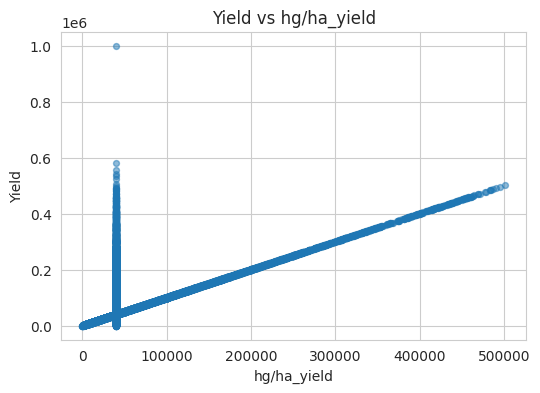


📊 Insight: The plot shows how yield varies with hg/ha_yield. 
A rising pattern suggests a positive effect, while a declining pattern shows negative impact.




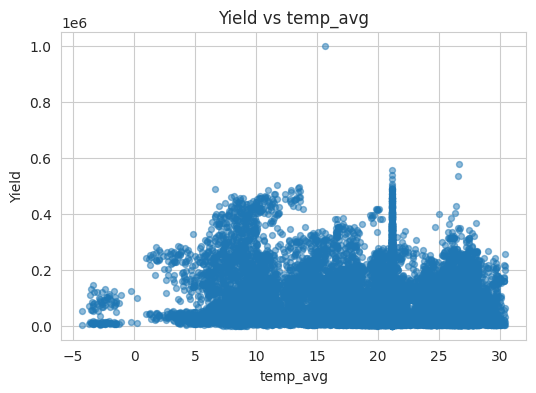


📊 Insight: The plot shows how yield varies with temp_avg. 
A rising pattern suggests a positive effect, while a declining pattern shows negative impact.




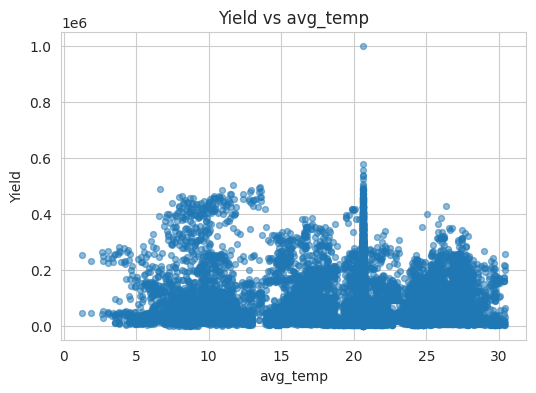


📊 Insight: The plot shows how yield varies with avg_temp. 
A rising pattern suggests a positive effect, while a declining pattern shows negative impact.




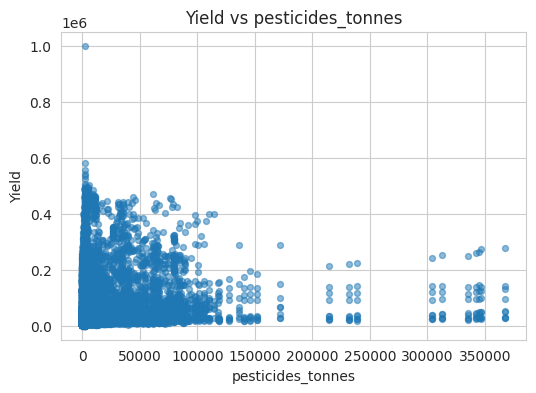


📊 Insight: The plot shows how yield varies with pesticides_tonnes. 
A rising pattern suggests a positive effect, while a declining pattern shows negative impact.




In [22]:
# Step 7: Correlation Analysis & Scatter Plots

corr = df[env_cols + ['yield']].corr()
print("Correlation with yield (sorted):")
print(corr['yield'].sort_values(ascending=False))

feat_corr = corr['yield'].abs().sort_values(ascending=False)
top_feats = feat_corr.index[1:5].tolist()
print("Top correlated features with yield:", top_feats)

for f in top_feats:
    plt.figure(figsize=(6,4))
    plt.scatter(df[f], df['yield'], alpha=0.5, s=18)
    plt.xlabel(f); plt.ylabel("Yield"); plt.title(f"Yield vs {f}")
    plt.show()
    print()
    print(f"📊 Insight: The plot shows how yield varies with {f}. "
          f"\nA rising pattern suggests a positive effect, while a declining pattern shows negative impact.\n")
    print("="*93 + "\n")